In [1]:
import sys
sys.path.append('../utils')

In [55]:
import fastf1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import pipeline

importlib.reload(pipeline)
from pipeline import extract_session_data, clean_session_data, get_driver_laps
from fastf1 import get_session

ImportError: cannot import name 'results' from 'fastf1' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastf1/__init__.py)

In [22]:
df_fp2 = extract_session_data(2025, "Austria", "FP2")
df_quali = extract_session_data(2025, "Austria", "Q")
df_race = extract_session_data(2025, "Austria", "R")

core           INFO 	Loading data for Austrian Grand Prix - Practice 2 [v3.4.4]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load result data from Ergast!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO

In [25]:
def extract_fp2_features(df):
    fp2_features = df.groupby("Driver").agg({
        "LapTime_s": ["mean", "min", "count"]
    })

    # Flatten column names
    fp2_features.columns = ["fp2_avg_lap", "fp2_best_lap", "fp2_total_laps"]
    fp2_features = fp2_features.reset_index()

    return fp2_features

In [26]:
fp2_features = extract_fp2_features(df_fp2)

In [28]:
fp2_features.head()
fp2_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Driver          20 non-null     object 
 1   fp2_avg_lap     20 non-null     float64
 2   fp2_best_lap    20 non-null     float64
 3   fp2_total_laps  20 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 772.0+ bytes


<Axes: xlabel='Driver', ylabel='fp2_avg_lap'>

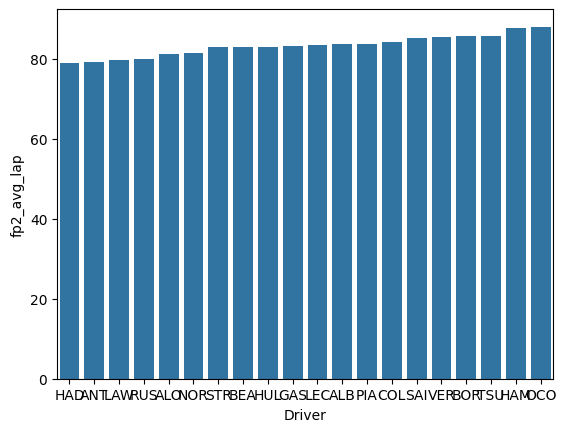

In [30]:
sns.barplot(data=fp2_features.sort_values('fp2_avg_lap'), x='Driver', y='fp2_avg_lap')

In [31]:
df_quali.head()
df_quali.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapNumber', 'Stint', 'PitOutTime',
       'PitInTime', 'Sector1SessionTime', 'Sector2SessionTime',
       'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
       'IsPersonalBest', 'Compound', 'TyreLife', 'FreshTyre', 'Team',
       'LapStartTime', 'LapStartDate', 'TrackStatus', 'Position', 'Deleted',
       'DeletedReason', 'FastF1Generated', 'IsAccurate', 'Sector1Time_s',
       'Sector2Time_s', 'Sector3Time_s', 'LapStartTime_s', 'LapTime_s',
       'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed'],
      dtype='object')

In [32]:
def extract_quali_features(df_quali: pd.DataFrame) -> pd.DataFrame:
    # Remove laps with NaN times
    df_quali = df_quali[df_quali['LapTime_s'].notna()]
    
    # Group by driver and take min lap time (fastest)
    fastest_laps = df_quali.groupby('Driver')['LapTime_s'].min().reset_index()
    fastest_laps.rename(columns={'LapTime_s': 'FastestQualiLap'}, inplace=True)
    
    # Optional: Assign grid positions by rank
    fastest_laps['QualiPosition'] = fastest_laps['FastestQualiLap'].rank(method='min').astype(int)

    return fastest_laps

In [34]:
quali_features = extract_quali_features(df_quali)
quali_features

,Driver,FastestQualiLap,QualiPosition
0,ALB,65.143,13
1,ALO,65.128,12
2,ANT,65.052,10
3,BEA,65.218,14
4,BOR,64.846,7
5,COL,65.278,15
6,GAS,64.846,7
7,HAD,65.063,11
8,HAM,64.582,4
9,HUL,65.606,20


In [36]:
full_features = pd.merge(fp2_features, quali_features, on='Driver', how='inner')
full_features

,Driver,fp2_avg_lap,fp2_best_lap,fp2_total_laps,FastestQualiLap,QualiPosition
0,ALB,83.720971,65.765,34,65.143,13
1,ALO,81.325815,65.457,27,65.128,12
2,ANT,79.124207,65.537,29,65.052,10
3,BEA,82.948310,65.835,29,65.218,14
4,BOR,85.753964,65.411,28,64.846,7
5,COL,84.304903,66.176,31,65.278,15
6,GAS,83.165909,65.613,33,64.846,7
7,HAD,79.064733,65.547,30,65.063,11
8,HAM,87.670516,65.511,31,64.582,4
9,HUL,83.085938,65.918,32,65.606,20


In [66]:
manual_positions = {
    "NOR" : 1,
    "PIA" : 2,
    "LEC" : 3,
    "HAM" : 4,
    "RUS" : 5,
    "LAW" : 6,
    "ALO" : 7,
    "BOR" : 8,
    "HUL" : 9,
    "OCO" : 10,
    "BEA" : 11,
    "HAD" : 12, 
    "GAS" : 13, 
    "STR" : 14,
    "COL" : 15,
    "TSU" : 16,
    "ALB" : 21,
    "VER" : 21,
    "ANT" : 21,
    "SAI" : 21
}
manual_positions

{'NOR': 1,
 'PIA': 2,
 'LEC': 3,
 'HAM': 4,
 'RUS': 5,
 'LAW': 6,
 'ALO': 7,
 'BOR': 8,
 'HUL': 9,
 'OCO': 10,
 'BEA': 11,
 'HAD': 12,
 'GAS': 13,
 'STR': 14,
 'COL': 15,
 'TSU': 16,
 'ALB': 21,
 'VER': 21,
 'ANT': 21,
 'SAI': 21}

In [69]:
official_results["RacePosition"] = official_results["Driver"].map(manual_positions)
official_results["DNF"] = official_results["RacePosition"] >= 21

In [70]:
official_results[["Driver", "RacePosition", "DNF"]]

,Driver,RacePosition,DNF
4,NOR,1,False
16,LEC,3,False
81,PIA,2,False
44,HAM,4,False
63,RUS,5,False
30,LAW,6,False
1,VER,21,True
5,BOR,8,False
12,ANT,21,True
10,GAS,13,False


In [72]:
# Merge on driver abbreviation
final_df = full_features.merge(official_results, on="Driver", how="inner")

In [73]:
final_df

,Driver,fp2_avg_lap,fp2_best_lap,fp2_total_laps,FastestQualiLap,QualiPosition,RacePosition,DNF
0,ALB,83.720971,65.765,34,65.143,13,21,True
1,ALO,81.325815,65.457,27,65.128,12,7,False
2,ANT,79.124207,65.537,29,65.052,10,21,True
3,BEA,82.948310,65.835,29,65.218,14,11,False
4,BOR,85.753964,65.411,28,64.846,7,8,False
5,COL,84.304903,66.176,31,65.278,15,15,False
6,GAS,83.165909,65.613,33,64.846,7,13,False
7,HAD,79.064733,65.547,30,65.063,11,12,False
8,HAM,87.670516,65.511,31,64.582,4,4,False
9,HUL,83.085938,65.918,32,65.606,20,9,False
